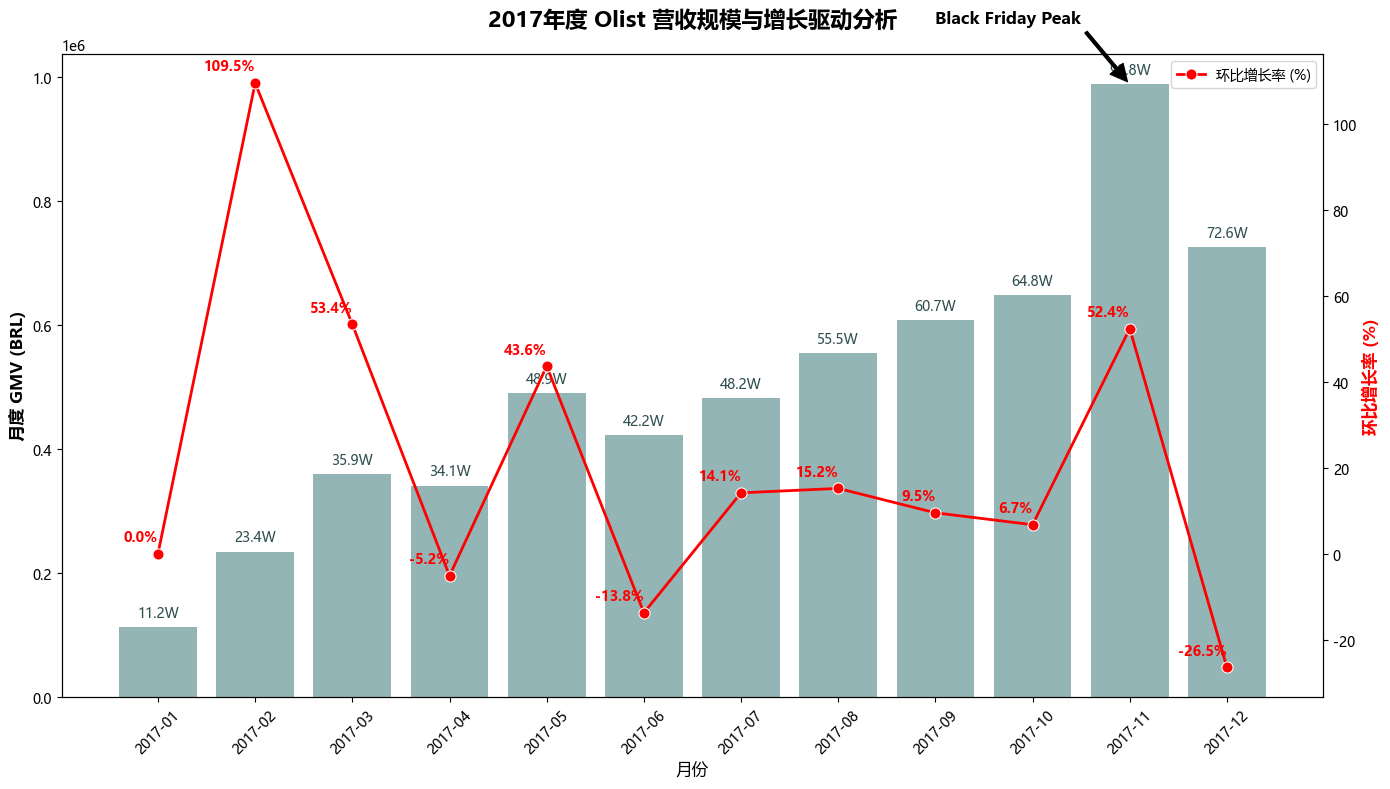

In [11]:
from config import * # Import all configurations
%matplotlib inline

# 1. 数据预处理优化
with open('../sql_scripts/05_monthly_mom_metrics.sql', 'r') as f:
    query = f.read()
df_plot = pd.read_sql(query, conn)

# 计算环比增长率
df_plot['mom_growth'] = (df_plot['current_month_gmv'] - df_plot['last_month_gmv']) / df_plot['last_month_gmv'] * 100

# 过滤 2017 年数据 如果是datetime类型 则用 df_plot[df_plot['month'].dt.year == 2017]
df_2017 = df_plot[df_plot['month'].str.startswith('2017')].copy()
df_2017.reset_index(drop=True, inplace=True)

# 优化：处理 1 月份的基数噪音
df_2017.loc[df_2017['month'] == '2017-01', 'mom_growth'] = 0  # 或者设为 None

# 2. 绘图：双轴复合图表
fig, ax1 = plt.subplots(figsize=(14, 8), dpi=100)

# 柱状图：月度 GMV (左轴)
bar = sns.barplot(x='month', y='current_month_gmv', data=df_2017, ax=ax1, alpha=0.7, color='#5F9EA0')
ax1.set_ylabel('月度 GMV (BRL)', fontsize=12, fontweight='bold')
ax1.set_xlabel('月份', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# 开启双轴 (右轴)
ax2 = ax1.twinx()
# 使用特定的 x 坐标确保折线点对准柱子中心
line = sns.lineplot(x=ax1.get_xticks(), y=df_2017['mom_growth'], ax=ax2, 
                    color='red', marker='o', markersize=8, linewidth=2, label='环比增长率 (%)')
ax2.set_ylabel('环比增长率 (%)', color='red', fontsize=12, fontweight='bold')
ax2.grid(False) # 关闭右轴网格线，避免画面太乱

# 3. 核心优化：添加数值标注
for i, row in df_2017.iterrows():
    # GMV 标注（单位换算为万，简洁美观）
    ax1.text(i, row['current_month_gmv'] + 10000, f"{row['current_month_gmv']/10000:.1f}W", 
             ha='center', va='bottom', fontsize=10, color='darkslategrey')
    # 增长率标注
    ax2.text(i, row['mom_growth'] + 2, f"{row['mom_growth']:.1f}%", 
             ha='right', va='bottom', fontsize=10, color='red', fontweight='bold')

# 4. 业务标注：2017-11 黑五效应
bf_idx = df_2017[df_2017['month'] == '2017-11'].index[0]
ax1.annotate('Black Friday Peak', xy=(bf_idx, df_2017.loc[bf_idx, 'current_month_gmv']), 
             xytext=(bf_idx-2, df_2017.loc[bf_idx, 'current_month_gmv'] + 100000),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
             fontsize=12, fontweight='bold', color='black')

plt.title('2017年度 Olist 营收规模与增长驱动分析', fontsize=16, pad=20, fontweight='bold')
fig.tight_layout()
plt.show()